## Построение метода распознавания для определения тех владельцев кредитных карт, которые не вернут кредит в срок. Метод CART


### Вопросы по результатам выполнения лабораторной:
1. Почему в дерево попало 20,1 к наблюдений, хотя во всём df 30 к наблюдений?
2. Также условие в верхнем узле написано df[df['PAY_0']<= 1.5]. Однако длина df с таким условием 26870 строк. Или я как-то неверно понял суть данного деления?
3. recall_score и precision_score отличаются от средних значений в classification_report

In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [3]:
os.chdir("C:/Users/danil/Desktop/Саморазвитие/ГПН/Labs/lab_6_А_К")

In [4]:
df = pd.read_csv('default of credit card clients.csv', sep = ';').drop(columns = ['ID'])  # колонка бесполезная, поэтому удалю её

In [5]:
from sklearn.model_selection import train_test_split  # для раздела выборки на тестовую и обучающую
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [12]:
len(df[df['PAY_0']<= 1.5])

26870

In [13]:
print('Количество мужчин в выборке: ', len(df[df['SEX'] == 1]))
print('Количество женщин в выборке: ', len(df[df['SEX'] == 2]))

Количество мужчин в выборке:  11888
Количество женщин в выборке:  18112


In [14]:
# Количество женщин и мужчин в выборке нормально сбалансированно, поэтому можно работать дальше
# Разделяем предикторы и отклик
X = df.iloc[:, :-1].values
Y = df.iloc[:, 23].values

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 13)

In [18]:
#  Параметры модели
model = DecisionTreeClassifier(random_state=13,
                               criterion='gini',
                               max_depth=6,  # максимальная глубина дерева
                               max_leaf_nodes=None, # максимальное число конечных узлов
                               min_samples_split=10,  # минимальное число элементов в узле для разбиения
                               min_samples_leaf=8,                                # минимальное число элементов в потомке
                               # минимальное значение уменьшения загрязнения (impurity)
                               min_impurity_decrease=0.001,
                               class_weight=None, # веса классов, сейчас 0
                               min_weight_fraction_leaf=0, # веса классов в потомке, сейчас 0
                               #  presort=False, # предварительная сортировка, 
                               # ускоряет обучение на данных малого размера или с ограниченной глубиной дерева.
                               splitter='best', # какое расщепление выбирать? ('best' или 'random'
                               max_features = None) # Перебирать все переменные

model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.001,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0, random_state=13)

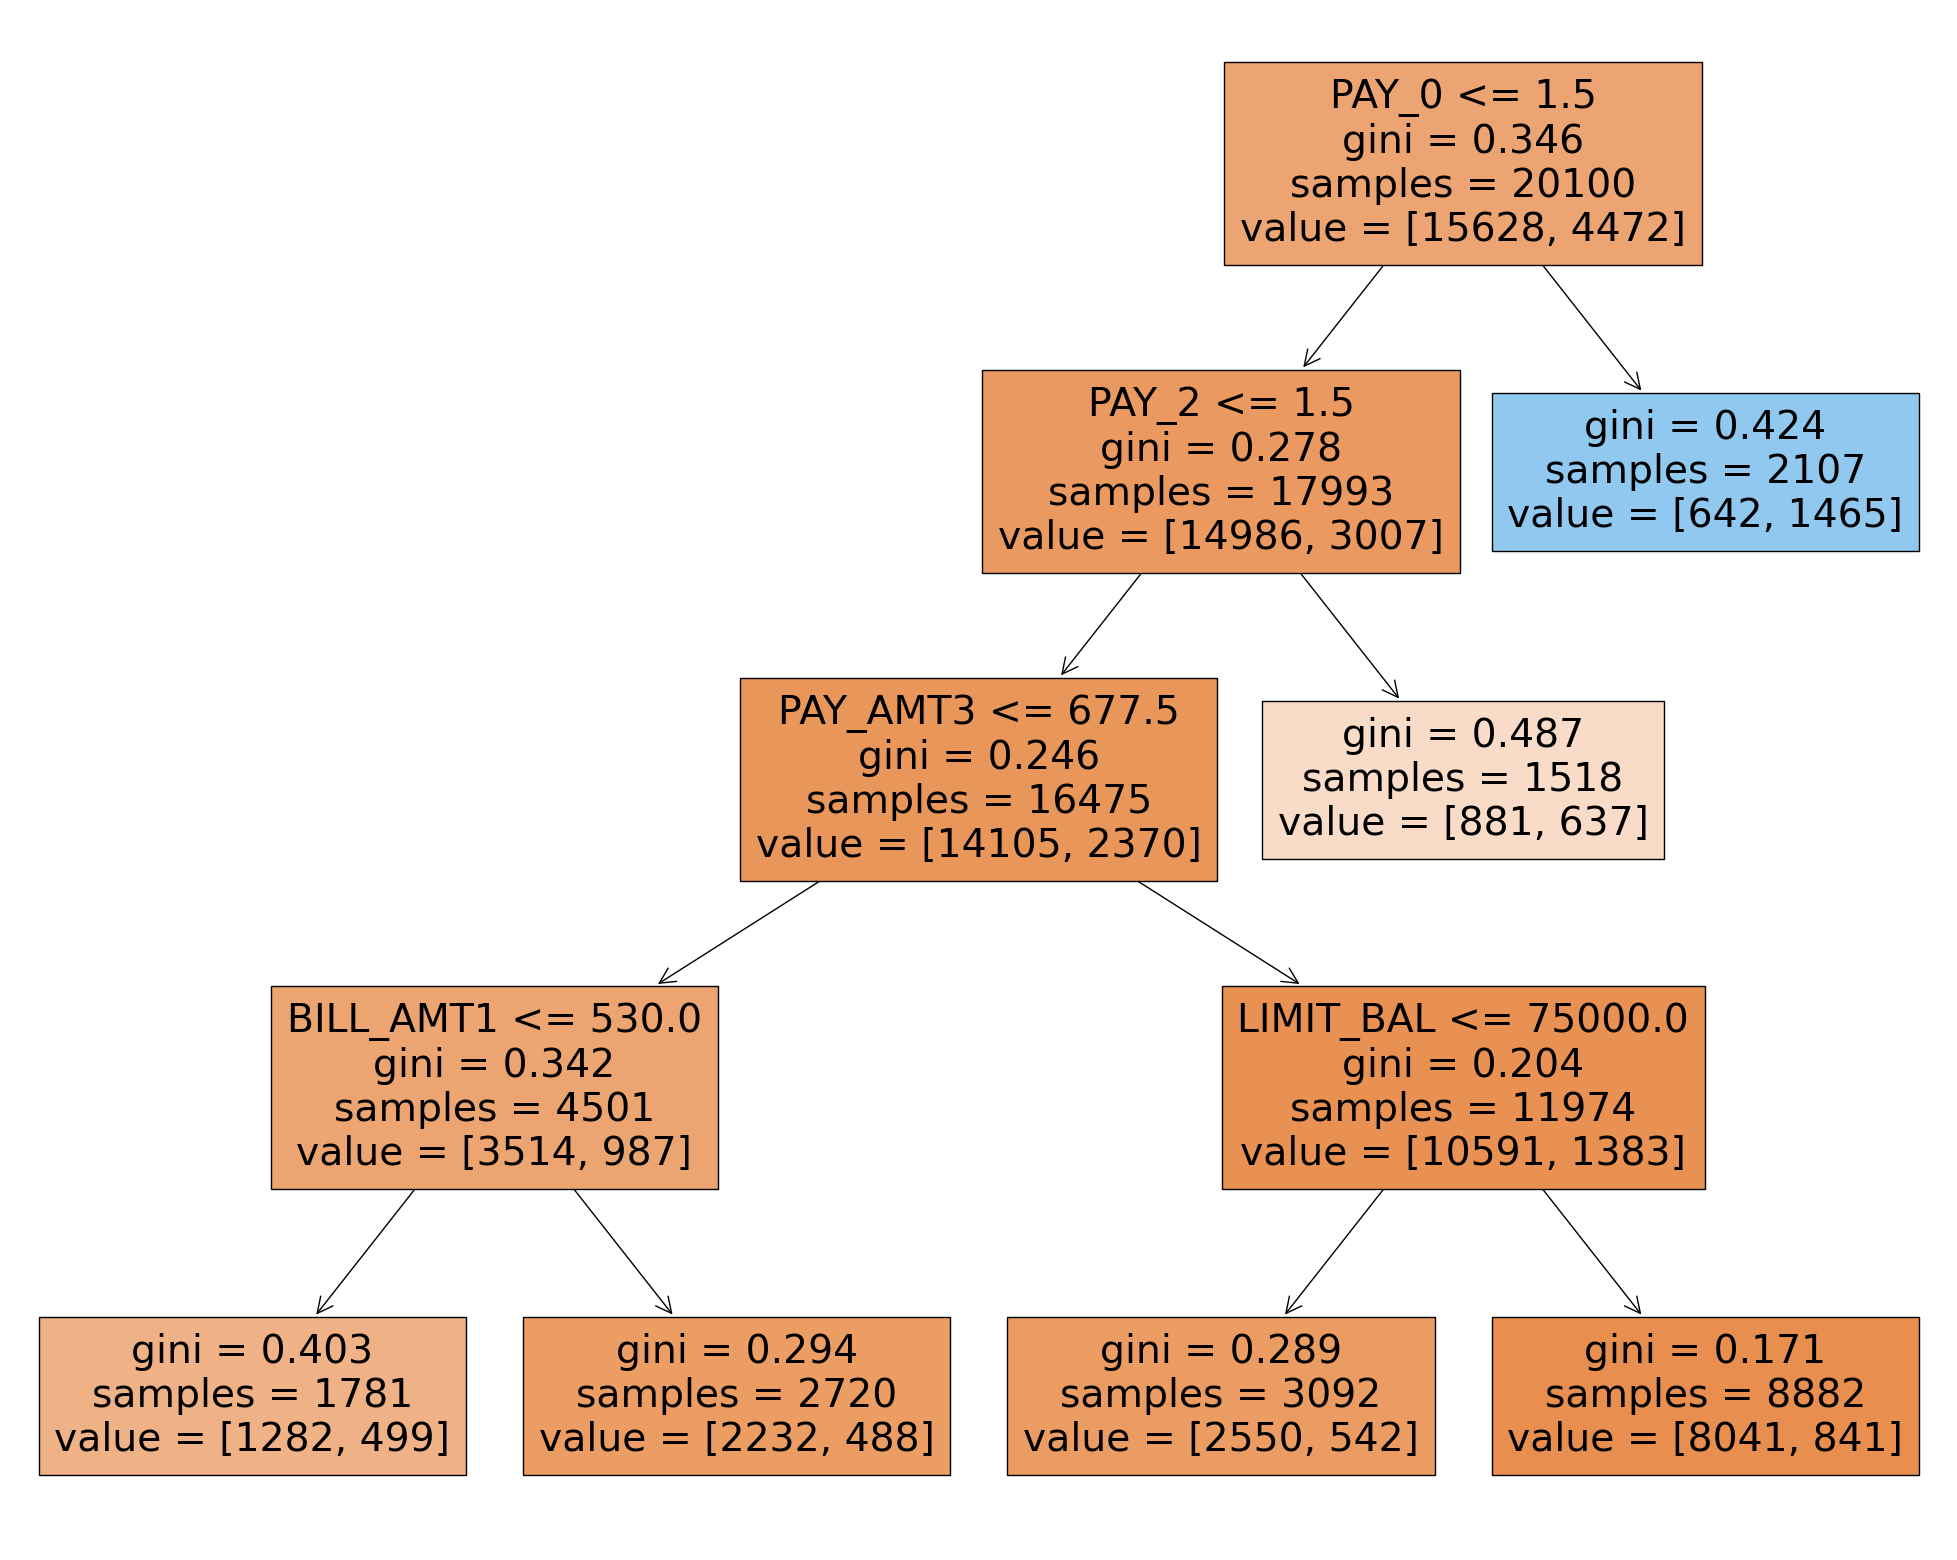

In [19]:
# визуализирую дерево. Заметно, что его глубина меньше максимальной, заданной при обучении
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names=df.columns, filled=True)

In [20]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [21]:
importance_df = pd.DataFrame({'feature': df.iloc[:, :-1].columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)
importance_df[importance_df['importance']==0]['feature'].tolist()    
# экспериментально подтвердилось, что в случае удаления этих колонок основные показатели качества модели не снижаются

['AGE',
 'MARRIAGE',
 'PAY_AMT5',
 'PAY_AMT4',
 'EDUCATION',
 'PAY_AMT2',
 'PAY_AMT1',
 'BILL_AMT6',
 'BILL_AMT5',
 'BILL_AMT4',
 'BILL_AMT3',
 'BILL_AMT2',
 'SEX',
 'PAY_6',
 'PAY_5',
 'PAY_4',
 'PAY_3',
 'PAY_AMT6']

In [22]:
print("Accuracy on train set is ", accuracy_score(Y_train, y_pred_train)*100)
print("Accuracy on test set is ", accuracy_score(Y_test, y_pred_test)*100)
print("Precision on test set is ", precision_score(Y_test, y_pred_test))
print("Recall on test set is ", recall_score(Y_test, y_pred_test))    

Accuracy on train set is  81.84577114427861
Accuracy on test set is  82.1919191919192
Precision on test set is  0.6959921798631477
Recall on test set is  0.3290203327171904


In [23]:
print(metrics.classification_report(y_pred_test, Y_test))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      8877
           1       0.33      0.70      0.45      1023

    accuracy                           0.82      9900
   macro avg       0.64      0.77      0.67      9900
weighted avg       0.89      0.82      0.85      9900



In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# Значения гиперпараметров
params_set = {
'max_depth': [c for c in range(3,7)],
'min_samples_leaf': [c for c in range(2,8)],
'min_samples_split': [c for c in range(4,14)]
}

#   Проводим 5-fold кросс-валидацию
#   Качество моделей сравниваем с помощью accuracy, так как классы сбалансированы
grid_CV_1 = GridSearchCV(estimator=model,
       param_grid=params_set,
       scoring='accuracy',
       cv=5,
       n_jobs=-1)


#   Обучение на обучающей выборке
grid_CV_1.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=6,
                                              min_impurity_decrease=0.001,
                                              min_samples_leaf=8,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0,
                                              random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                               13]},
             scoring='accuracy')

In [26]:
#   Лучший набор значений гиперпараметров

best_hyperparams = grid_CV_1.best_params_
print('Лучшие значения гиперпараметров:\n', best_hyperparams)

Лучшие значения гиперпараметров:
 {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [27]:
# Значение критерия качества для лучших значений гиперпараметров 
best_CV_score = grid_CV_1.best_score_
print('Лучшее accuracy', best_CV_score)

Лучшее accuracy 0.817910447761194


In [28]:
# Лучшая модель
best_model = grid_CV_1.best_estimator_

# accuracy на тестовом множестве для лучшей модели
test_acc = best_model.score(X_test,Y_test)

# Значение критерия качества для лучших значений гиперпараметров 
print('Лучшее accuracy на тестовом множестве CART', round(test_acc,4))
print('Лучшее accuracy на тестовом множестве методом KNN', 0.8065)     

Лучшее accuracy на тестовом множестве CART 0.8219
Лучшее accuracy на тестовом множестве методом KNN 0.8065


In [31]:
# Строим предсказание модели
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [32]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(Y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)
conf_mat

,0,1
0,7425,311
1,1452,712


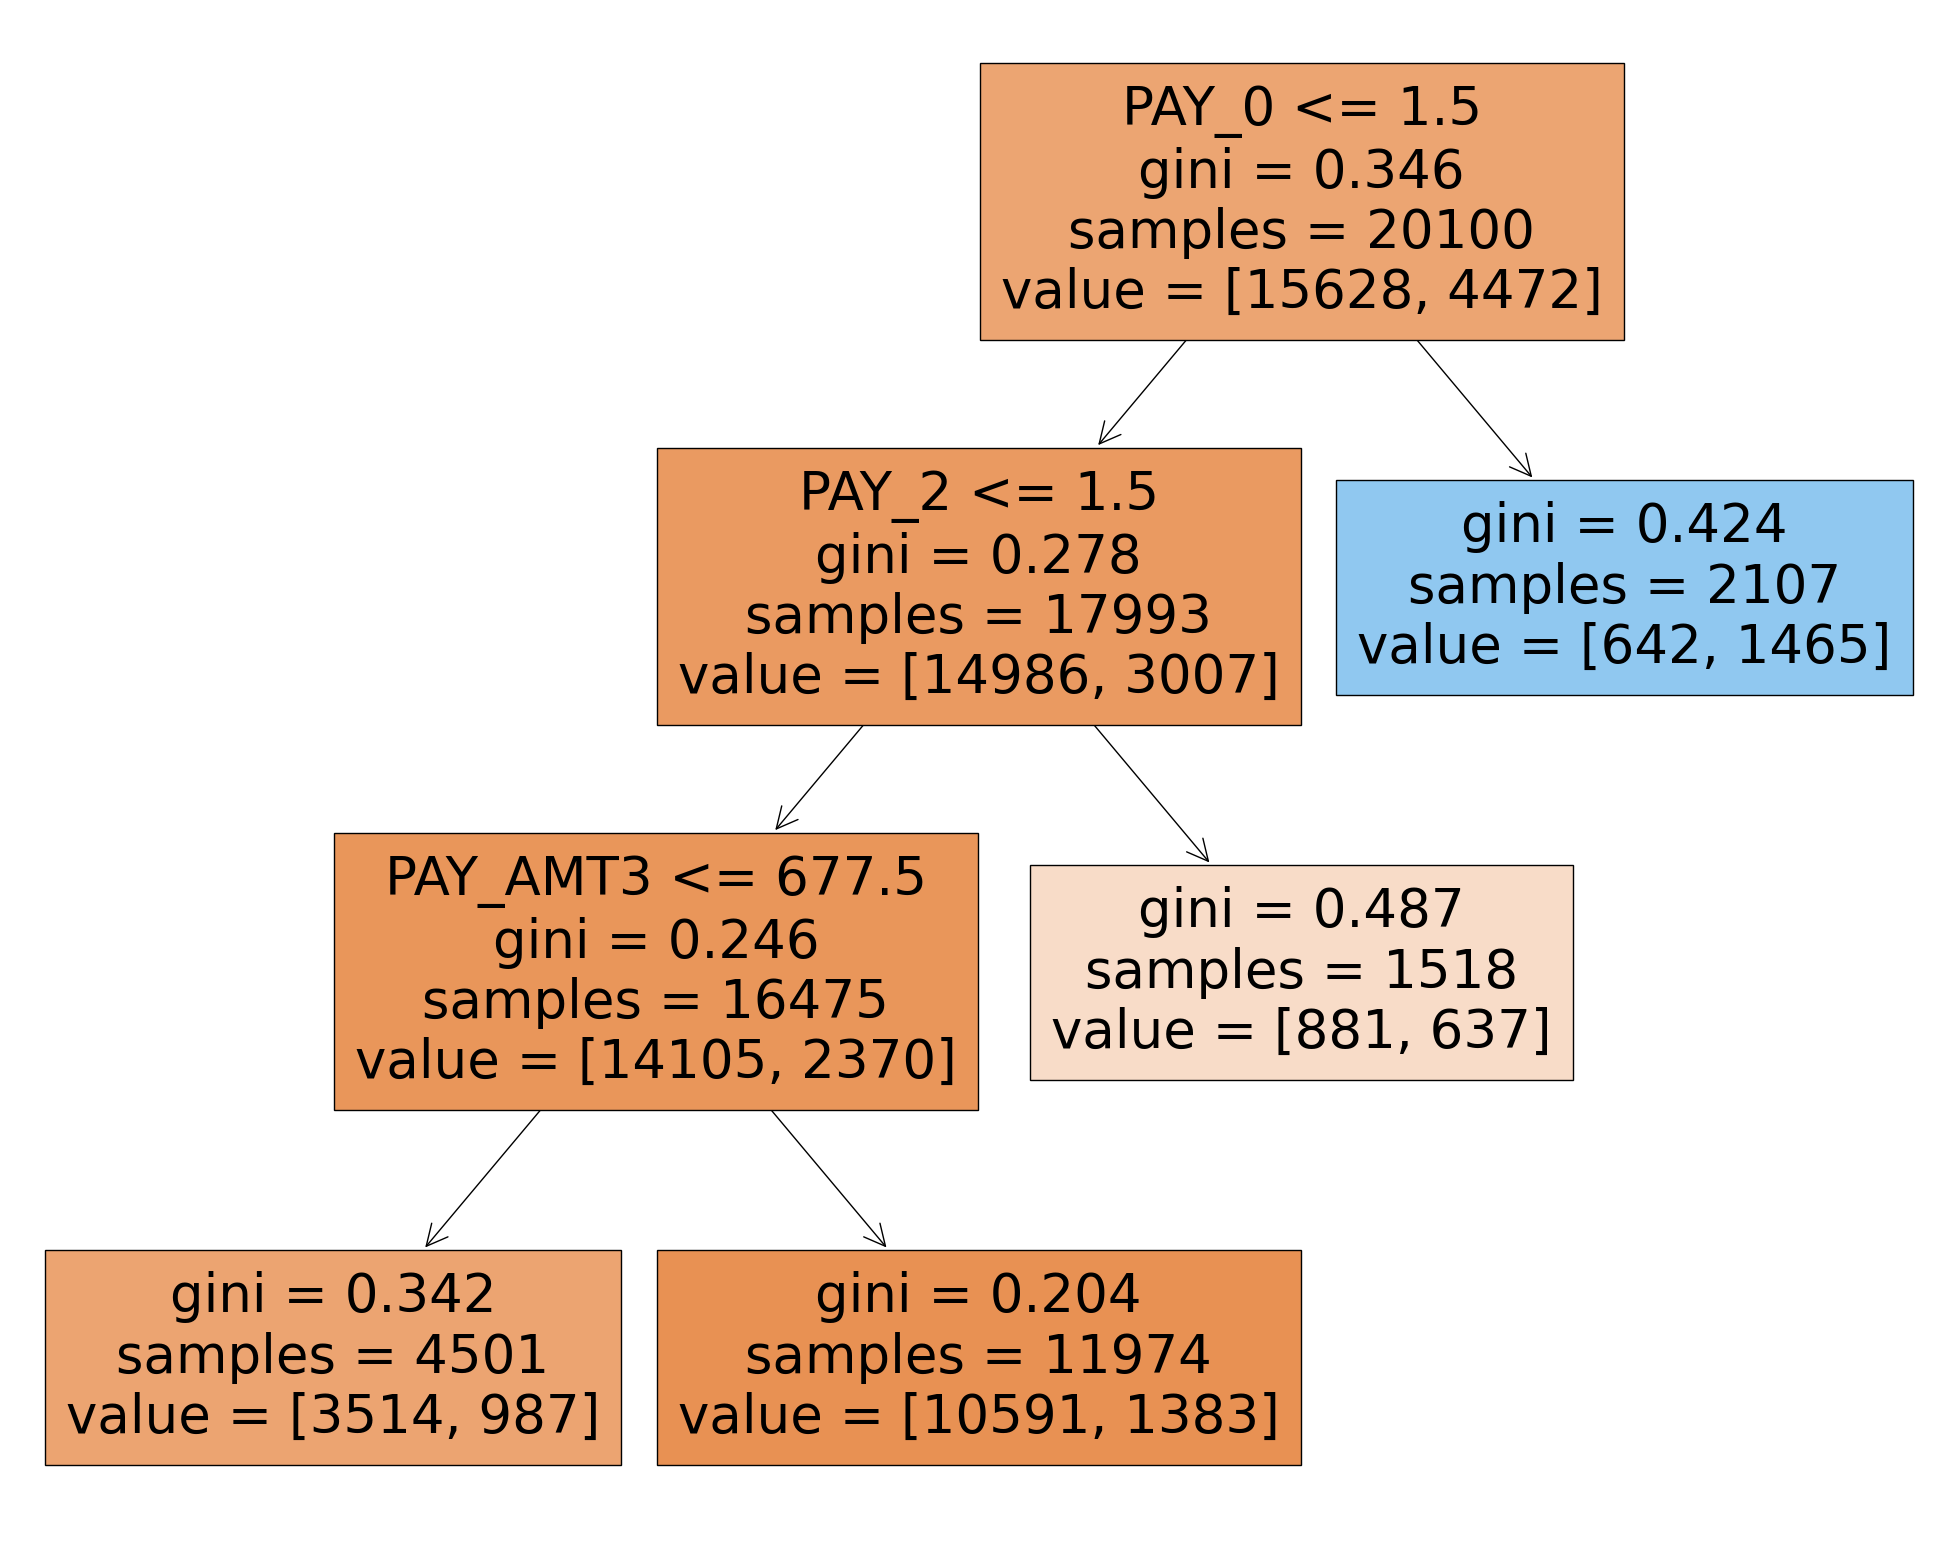

In [33]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, feature_names=df.columns, filled=True)

Таким образом, была получена модель с более высоким accuracy, чем у метода KNN. Однако при Gridsearch лучшими параметрами для модели были определены крайние параметры в словаре params_set